## Dataset

Dataset is about bike rental service. It contains bike sharing counts aggregated on hourly basis. Total number of records: 17379 hours (2 years of rental services). There are following features:
- instant: record index
- dteday : date of record
- hr : hour (0 to 23) of record
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : weather situation in the current timeframe
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users (target 1)
- registered: count of registered users (target 2)
- cnt: count of total rental bikes including both casual and registered (target total)

## Task

- Preprocessing (1 point)
- Feature engineering (2 points)
- Use different advanced regression algorithms:
    - KNN Regressor (1 point)
    - Decision Tree Regressor (1 point) 
    - Random Forest / Extra Trees Regressor (1 point)
    - SVM Regressor (1 point)
    - Boosting Regressor - any Boosting algorithm with Regression (1 point)
    - Any other regression algorithm besides Linear, Ridge, Lasso and used above. (1 point)

NB! The task is considered done for each model if there is hyperparameters tuning and validation is used. 
- Build regression model for each year in question (2 points):
    - Target is cnt, exclude casual and registered from the model
    - Validate either on last 7 days of each months or on random subsample
    - Check the quality of prediction
    - Build regression model based on the first year data and make predictions for the second year (you should validate first year model on itself, similarly to previous task) . The results are better or worse? Why? (1 point)
- Build regression model for each year in question (2 points):
    - Multitarget: casual and registered, exclude cnt from the model
    - Validate either on last 7 days of each months or on random subsample
    - Check the quality of prediction
    - Use the sum of two targets two predict cnt. Estimate the quality. Is it higher than for one-target model? (1 point)
- In the process of completion, answer the following questions:
    - How the temperature and humidity influences rental count rates? What is more important - temperature or feeling temperature? (2 point)
    - What are the most influentual features? (2 points)
    - What is more important: current season or current hour? (1 point)

Total points: 20. Threshold for completion: 15 points.    

**IMPORTS**

In [142]:
import numpy as np
import pandas as pd

from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import chi2

import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from tqdm.notebook import tqdm as tqdm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import  train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn_pandas import DataFrameMapper

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

**FUNCTIONS AND CONSTANTS**

**DATASET PREPROCESSING**

In [143]:
df = pd.read_csv(r'C:\Users\1\Desktop\HW\hour.csv', index_col='instant')
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [144]:
df.shape

(17379, 16)

In [145]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000


- Most of the features have the minimum value of 0 which might introduce boundaries to transformations
- There are 3 dummies already: `yr`, `holiday`, `workingday`

In [146]:
df.isna().sum().sum()

0

**DATE FEATURES**

Currently, date features are:
- year
- month
- weekday
- holiday
- working day
- hour

We only lack the `day of the month` for full date info to be represented as separate features.

In [147]:
df['day'] = pd.to_datetime(df['dteday']).dt.day

**Transforming date features into cyclical**

Some date features need to be transformed to represent cyclicality
- month
- weekday
- day of the month
- hour

In [148]:
df['month_sin'] = np.sin(df.mnth*(2.*np.pi/12))
df['month_cos'] = np.cos(df.mnth*(2.*np.pi/12))

df['day_sin'] = np.sin(df.day*(2.*np.pi/30))
df['day_cos'] = np.cos(df.day*(2.*np.pi/30))

df['weekday_sin'] = np.sin(df.weekday*(2.*np.pi/7))
df['weekday_cos'] = np.cos(df.weekday*(2.*np.pi/7))

df['hour_sin'] = np.sin(df.hr*(2.*np.pi/24))
df['hour_cos'] = np.cos(df.hr*(2.*np.pi/24))

**ENCODING CATEGORICAL VARIABLES**

Mostly, all the categorical variables are encoded properly already. For example, `weathersit` encoding reflects the ordinal relationship between the variable levels.

Therefore, it can be argued that only one variable is not encoded properly for regression — `season`. One-hot encoder is used to create a separate dummy for each season. 

In [149]:
season_encoded = pd.get_dummies(df.season)
season_encoded = season_encoded.rename(columns={1: "spring", 2: "summer", 3: "fall", 4: "winter"})

In [150]:
df = df.merge(season_encoded, on='instant', how='left')

Now we can drop the redundant non-encoded feature columns.

In [151]:
df = df.drop(['season', 'dteday', 'mnth', 'hr', 'weekday', 'day'], axis=1)

In [152]:
df.columns

Index(['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin',
       'hour_cos', 'spring', 'summer', 'fall', 'winter'],
      dtype='object')

**UNIVARIATE ANALYSIS**

Let's look at the distributions of the variables.

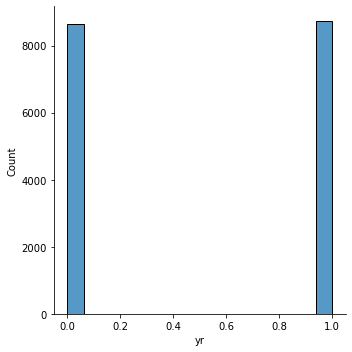

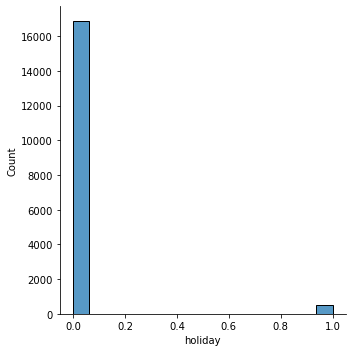

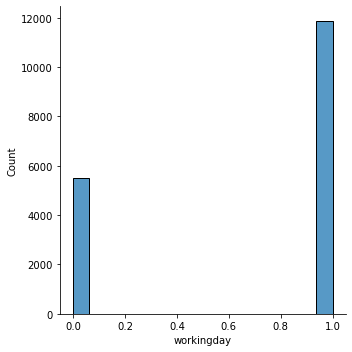

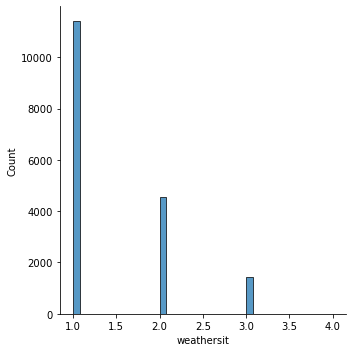

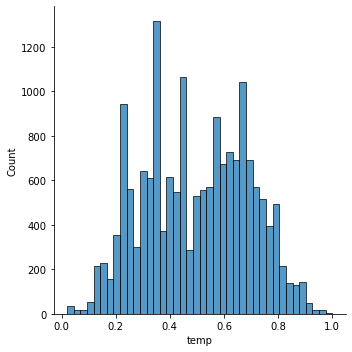

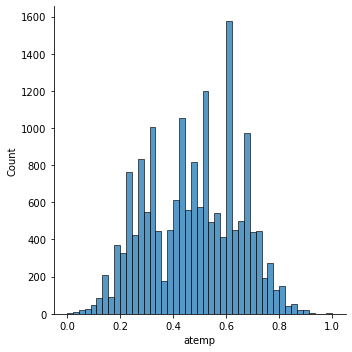

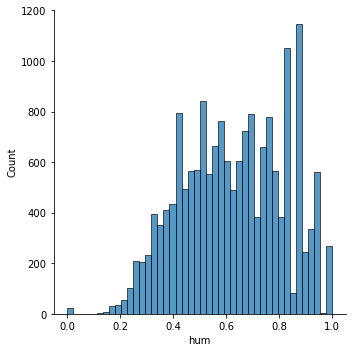

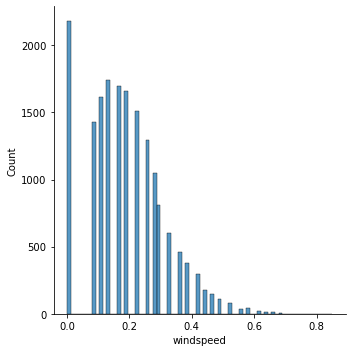

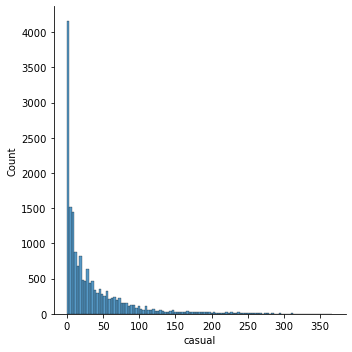

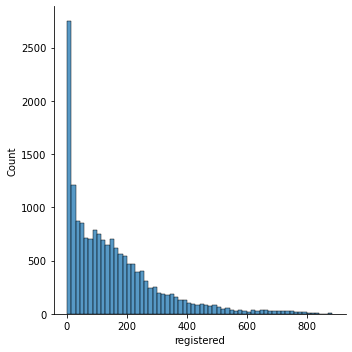

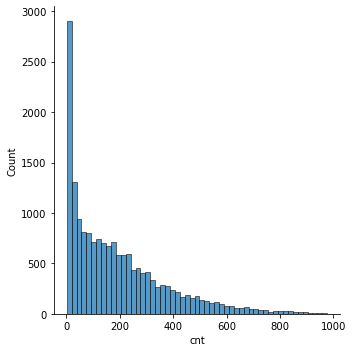

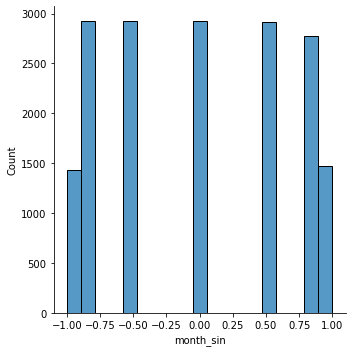

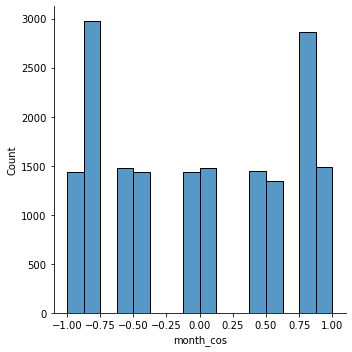

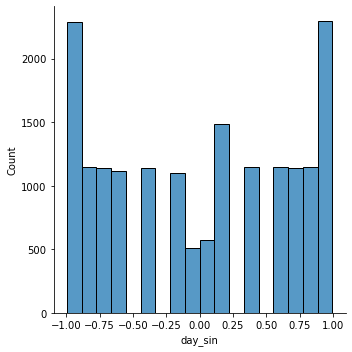

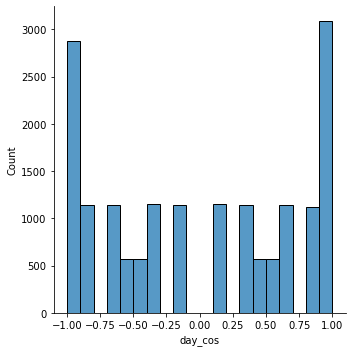

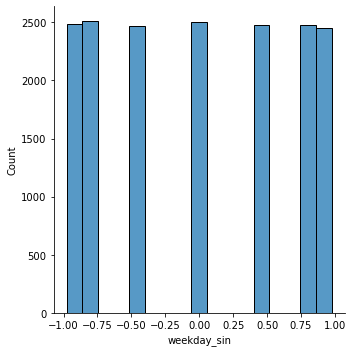

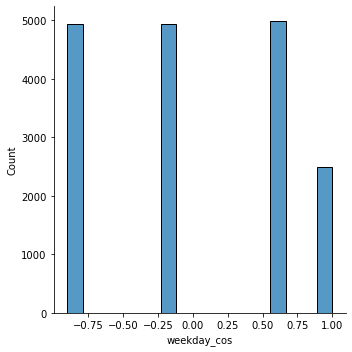

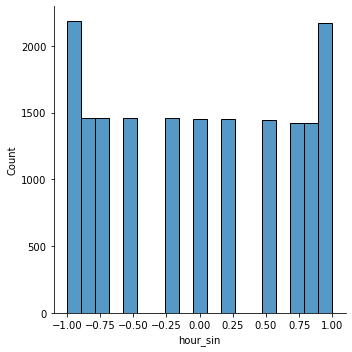

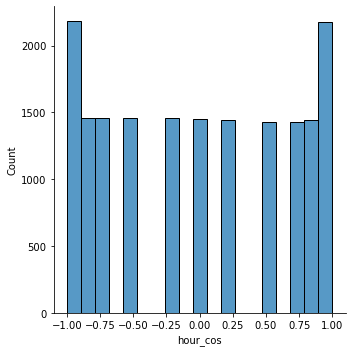

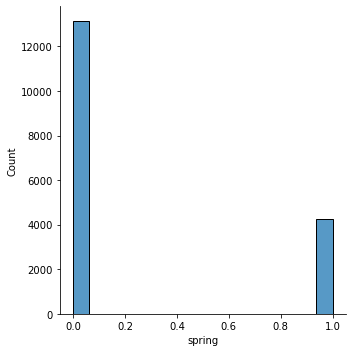

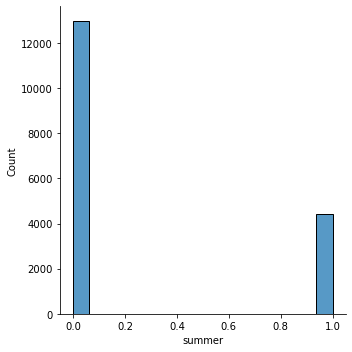

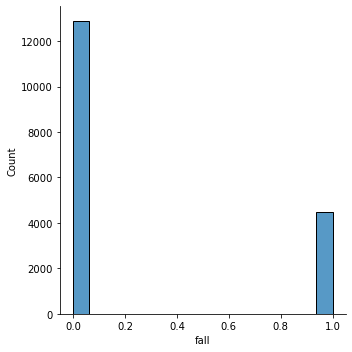

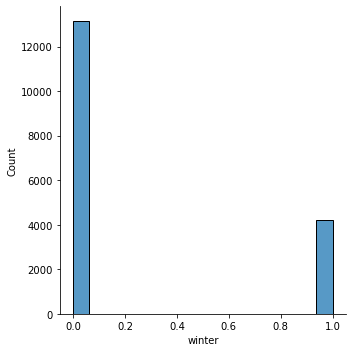

In [153]:
for col in df.columns:
    sns.displot(df[col])

Some of the features will require transformations before further analysis.

In [154]:
TO_TRANSFORM = ['hum', 'windspeed', 'casual', 'registered', 'cnt']
DUMMIES = ['yr', 'holiday', 'workingday', 'spring', 'summer', 'fall', 'winter']
NO_TRANSFORM = df.columns.drop(TO_TRANSFORM).drop(DUMMIES)

**BIVARIATE ANALYSIS**

Now let's examine the relationship between the total rental count `cnt` and the predictors. 

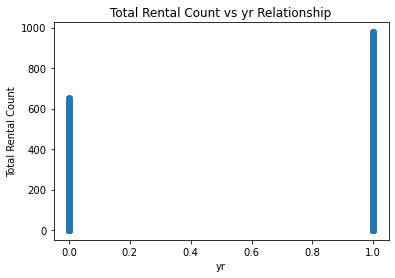

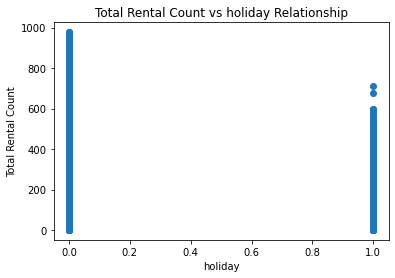

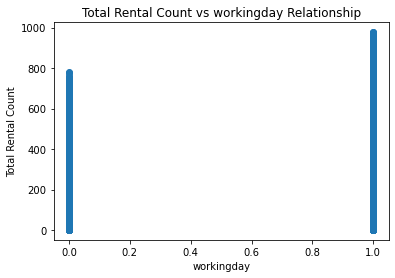

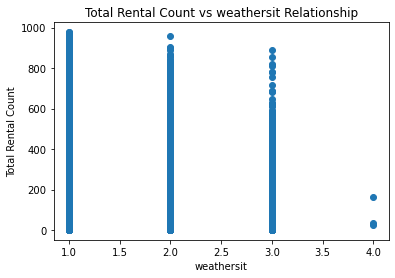

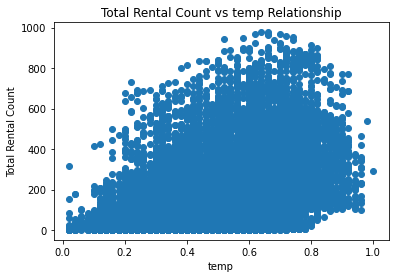

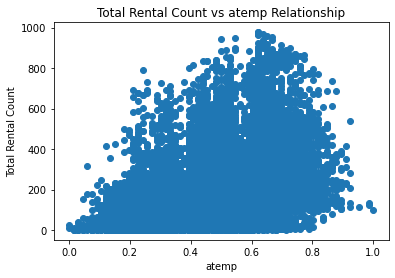

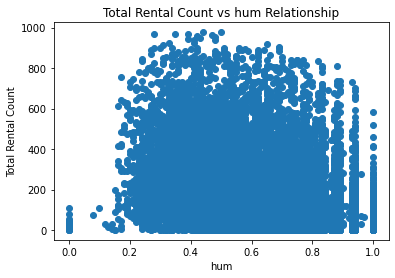

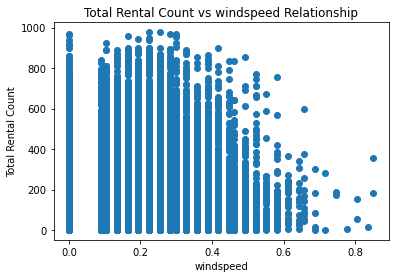

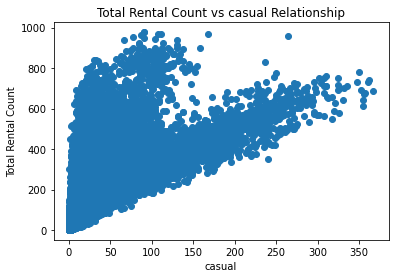

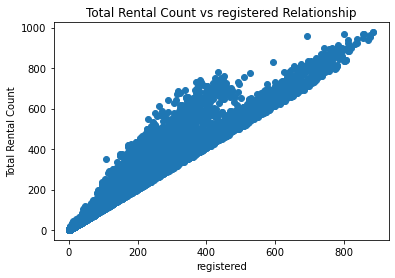

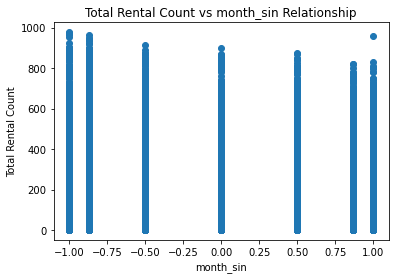

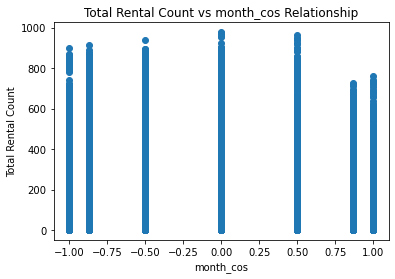

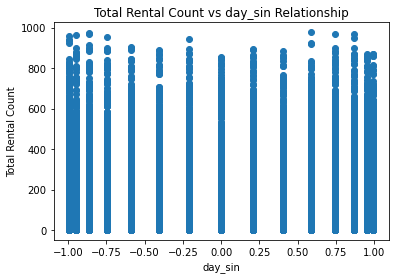

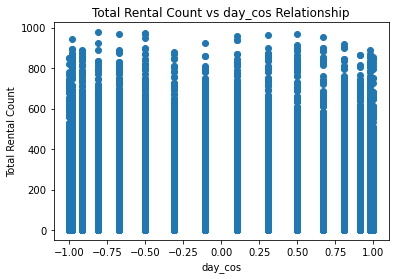

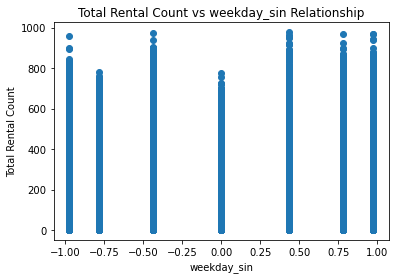

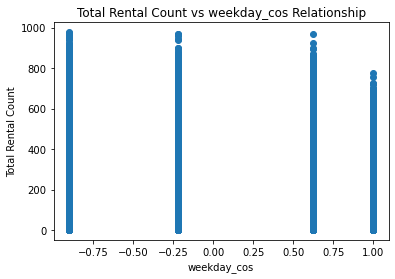

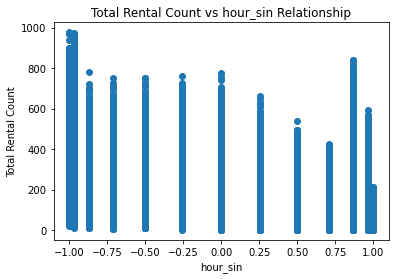

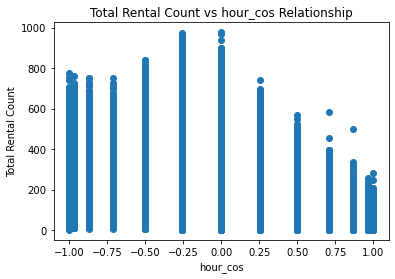

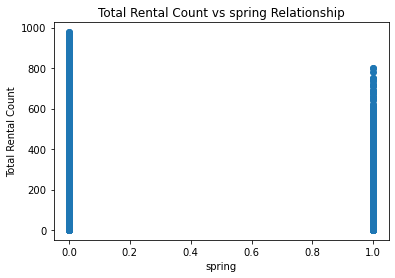

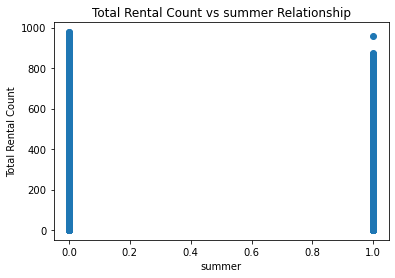

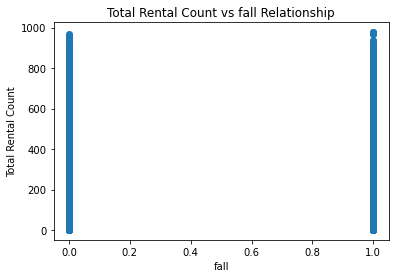

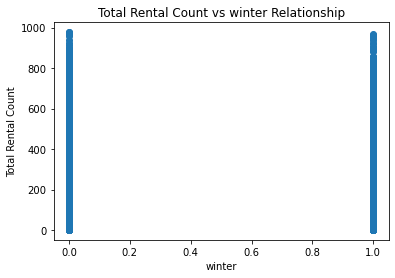

In [155]:
for col in df.columns.drop('cnt'):
    ax = plt.gca()
    ax.scatter(x=df[col], y=df['cnt'])
    ax.set_xlabel(col)
    ax.set_ylabel('Total Rental Count')
    ax.set_title("Total Rental Count vs {} Relationship".format(col))
    plt.show();

It can be argued from the scatterplots that `temp` and `atemp` have **positive association** with the total rental count `cnt`. As to `hum` variable, a slightly negative relationship can be inferred.

Creating a DF for transformed variables.

In [156]:
X_tr = pd.DataFrame()
X_tr = df[NO_TRANSFORM]

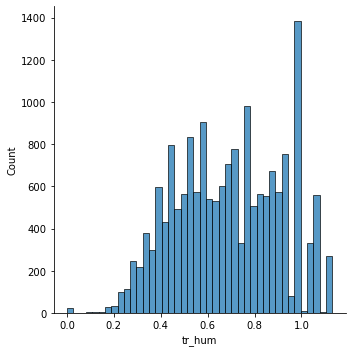

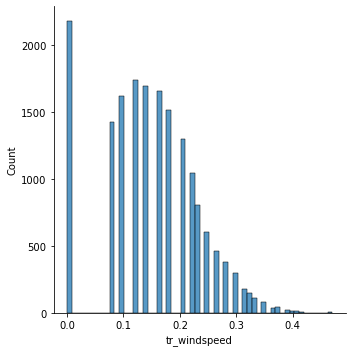

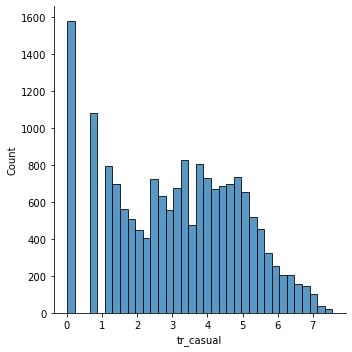

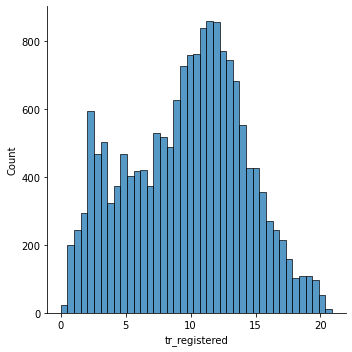

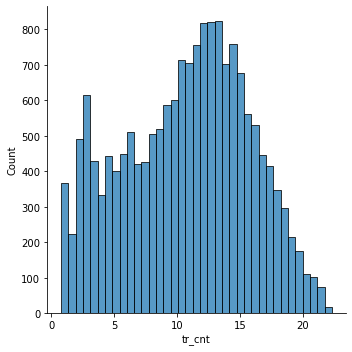

In [157]:
for col in TO_TRANSFORM:
    X_tr['tr_{}'.format(col)], lam = yeojohnson(df[col])
    sns.displot(X_tr['tr_{}'.format(col)])

Now the distributions look a bit better.

In [158]:
X_tr.head()

,weathersit,temp,atemp,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,tr_hum,tr_windspeed,tr_casual,tr_registered,tr_cnt
instant,,,,,,,,,,,,,,,,
1,1,0.24,0.2879,0.5,0.866025,0.207912,0.978148,-0.781831,0.62349,0.000000,1.000000,0.898859,-0.0,1.466196,3.942703,4.418906
2,1,0.22,0.2727,0.5,0.866025,0.207912,0.978148,-0.781831,0.62349,0.258819,0.965926,0.886814,-0.0,2.402447,6.011571,6.726526
3,1,0.22,0.2727,0.5,0.866025,0.207912,0.978148,-0.781831,0.62349,0.500000,0.866025,0.886814,-0.0,1.926720,5.574843,6.101011
4,1,0.24,0.2879,0.5,0.866025,0.207912,0.978148,-0.781831,0.62349,0.707107,0.707107,0.826906,-0.0,1.466196,3.446646,3.985379
5,1,0.24,0.2879,0.5,0.866025,0.207912,0.978148,-0.781831,0.62349,0.866025,0.500000,0.826906,-0.0,0.000000,0.766707,0.768698


Before building the models with this dataset, it needs to be scaled.

In [159]:
mapper = DataFrameMapper([(X_tr.columns, StandardScaler())])
scaled = mapper.fit_transform(X_tr.copy())
X_tr_scaled = pd.DataFrame(scaled, index=X_tr.index, columns=X_tr.columns)

In [160]:
X_tr_scaled = X_tr_scaled.merge(df[DUMMIES], how='left', on='instant')

The preprocessed dataset that will be used in the analysis.

In [161]:
X_tr_scaled.head()

,weathersit,temp,atemp,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,...,tr_casual,tr_registered,tr_cnt,yr,holiday,workingday,spring,summer,fall,winter
instant,,,,,,,,,,,,,,,,,,,,,
1,-0.665193,-1.334648,-1.093281,0.716647,1.231031,0.286755,1.359488,-1.101806,0.876391,0.006379,...,-0.906359,-1.261875,-1.252934,0,0,0,1,0,0,0
2,-0.665193,-1.438516,-1.181732,0.716647,1.231031,0.286755,1.359488,-1.101806,0.876391,0.372567,...,-0.396991,-0.804152,-0.791386,0,0,0,1,0,0,0
3,-0.665193,-1.438516,-1.181732,0.716647,1.231031,0.286755,1.359488,-1.101806,0.876391,0.713799,...,-0.655811,-0.900775,-0.916496,0,0,0,1,0,0,0
4,-0.665193,-1.334648,-1.093281,0.716647,1.231031,0.286755,1.359488,-1.101806,0.876391,1.006822,...,-0.906359,-1.371624,-1.339644,0,0,0,1,0,0,0
5,-0.665193,-1.334648,-1.093281,0.716647,1.231031,0.286755,1.359488,-1.101806,0.876391,1.231667,...,-1.704042,-1.964542,-1.983013,0,0,0,1,0,0,0


In [162]:
corr = X_tr_scaled.corr()

<AxesSubplot:>

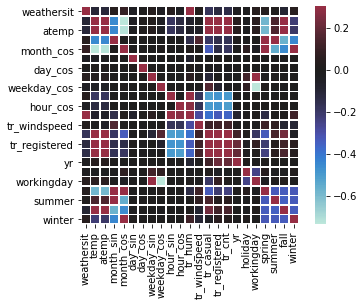

In [163]:
sns.heatmap(corr, vmax=.3, center=0, square=True, linewidths=0.5)

- Significant correlations are found neither between the transformed target `cnt` with the predictors (incl. `registered` and `casual`) nor among the predictors themselves.
+ As to the `cnt` association with the `temp`, `atemp`, and `hum` variables, we can conclude from the matrix and the abovementioned bivariate plots:
    - There is slightly positive relationship between `cnt` and `temp`/`atemp`
    - There is slightly negative relationship between `cnt` and `hum`


**TRAIN / TEST SPLIT**

! Assuming dropping `casual` and `registered` as predictors from Part 1.

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tr_scaled.drop(['tr_casual', 'tr_registered', 'tr_cnt'], axis=1), X_tr_scaled['tr_cnt'], test_size=0.3)

**PART 1. ADVANCED REGRESSION MODELS**

In this section, several advanced regression models will be compared and the best one will be chosen for further analysis.

In [165]:
def CV(model, X, y, cv):
    fitted = model.fit(X,y)
    CV_score = np.mean(cross_val_score(estimator = fitted, X = X, y = y, cv = cv))
    print('Mean CV score for 5 folds = {}'.format(CV_score))

In [166]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

1. **KNN Regressor**

In [167]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
y_pred_knr = knr.predict(X_test)
print(f'R2 score: {r2_score(y_pred_knr, y_test)}')

R2 score: 0.674896538586387


In [168]:
knr_hp = [{'n_neighbors': (2, 10, 1), 'weights': ['uniform','distance']}]

In [169]:
grid_knr = GridSearchCV(estimator=knr, param_grid=knr_hp, cv=kfold, scoring='r2')
grid_knr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': (2, 10, 1),
                          'weights': ['uniform', 'distance']}],
             scoring='r2')

In [170]:
print('Best R2 score: {}'.format(grid_knr.best_score_))
print(grid_knr.best_estimator_)
print(grid_knr.best_params_)

Best R2 score: 0.7929432426768483
KNeighborsRegressor(n_neighbors=10, weights='distance')
{'n_neighbors': 10, 'weights': 'distance'}


In [172]:
knr = KNeighborsRegressor(**grid_knr.best_params_)

In [173]:
CV(knr, X_train, y_train, kfold)

Mean CV score for 5 folds = 0.7929432426768483


2. **Decision Tree Regressor**

In [174]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)
print(f'R2 score: {r2_score(y_pred_dtr, y_test)}')

R2 score: 0.9028485417842228


In [175]:
dtr_hp = [{'max_depth': (1, 10, 1), 'min_samples_split': (1, 10, 1)}]

In [176]:
grid_dtr = GridSearchCV(estimator=dtr, param_grid=dtr_hp, cv=kfold, scoring='r2')
grid_dtr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': (1, 10, 1),
                          'min_samples_split': (1, 10, 1)}],
             scoring='r2')

In [177]:
print('Best R2 score: {}'.format(grid_dtr.best_score_))
print(grid_dtr.best_estimator_)
print(grid_dtr.best_params_)

Best R2 score: 0.9091867656102742
DecisionTreeRegressor(max_depth=10, min_samples_split=10)
{'max_depth': 10, 'min_samples_split': 10}


In [178]:
dtr = DecisionTreeRegressor(**grid_dtr.best_params_)

In [179]:
CV(dtr, X_train, y_train, kfold)

Mean CV score for 5 folds = 0.9092842064554935


3. **Random Forest Regressor**

In [180]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
print(f'R2 score: {r2_score(y_pred_rfr, y_test)}')

R2 score: 0.9535768983584881


In [181]:
rfr_hp = [{'n_estimators': (1, 30, 1), 'max_depth': (1, 10, 1), 'min_samples_split': (1, 15, 1)}]

In [182]:
grid_rfr = GridSearchCV(estimator=rfr, param_grid=rfr_hp, cv=kfold, scoring='r2')
grid_rfr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': (1, 10, 1),
                          'min_samples_split': (1, 15, 1),
                          'n_estimators': (1, 30, 1)}],
             scoring='r2')

In [183]:
print('Best R2 score: {}'.format(grid_rfr.best_score_))
print(grid_rfr.best_estimator_)
print(grid_rfr.best_params_)

Best R2 score: 0.9376209509227994
RandomForestRegressor(max_depth=10, min_samples_split=15, n_estimators=30)
{'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 30}


In [184]:
rfr = RandomForestRegressor(**grid_rfr.best_params_)

In [185]:
CV(rfr, X_train, y_train, kfold)

Mean CV score for 5 folds = 0.9374733576360981


4. **SVM Regressor**

Firstly, dimensionality reduction is required.

In [186]:
pca = PCA(n_components=2)

In [187]:
X_train_pc = pca.fit_transform(X_train)
X_test_pc = pca.fit_transform(X_test)

In [188]:
#svr = SVR(C=500000, kernel='rbf')
#svr.fit(X_train_pc, y_train)
#y_pred = svr.predict(X_test_pc)
#print(f'R2 score: {r2_score(y_pred, y_test)}')

5. **Boosting Regressor — AdaBoostRegressor** 

In [197]:
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
abr.fit(X_train, y_train)
y_pred_abr = abr.predict(X_test)
print(f'R2 score: {r2_score(y_pred_abr, y_test)}')

R2 score: 0.9552483529925221


In [198]:
abr.get_params().keys()

dict_keys(['base_estimator__ccp_alpha', 'base_estimator__criterion', 'base_estimator__max_depth', 'base_estimator__max_features', 'base_estimator__max_leaf_nodes', 'base_estimator__min_impurity_decrease', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'base_estimator__min_samples_split', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__random_state', 'base_estimator__splitter', 'base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [199]:
abr_hp = [{'n_estimators': (1, 30, 1), 'base_estimator__max_depth': (1, 10, 1), 'base_estimator__min_samples_split': (1, 15, 1)}]

In [200]:
grid_abr = GridSearchCV(estimator=abr, param_grid=abr_hp, cv=kfold, scoring='r2')
grid_abr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),
             param_grid=[{'base_estimator__max_depth': (1, 10, 1),
                          'base_estimator__min_samples_split': (1, 15, 1),
                          'n_estimators': (1, 30, 1)}],
             scoring='r2')

In [201]:
print('Best R2 score: {}'.format(grid_abr.best_score_))
print(grid_abr.best_estimator_)
print(grid_abr.best_params_)

Best R2 score: 0.9481542805082928
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                       min_samples_split=15),
                  n_estimators=30)
{'base_estimator__max_depth': 10, 'base_estimator__min_samples_split': 15, 'n_estimators': 30}


In [202]:
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                       min_samples_split=15),
                       n_estimators=30)

In [203]:
CV(abr, X_train, y_train, kfold)

Mean CV score for 5 folds = 0.9484830988353614


6. **XGBRegressor**

In [221]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(f'R2 score: {r2_score(y_pred_xgb, y_test)}')

R2 score: 0.9614814900474693


In [190]:
#xgb.get_params()

In [192]:
#xgb_hp = [{'n_estimators': (50, 200, 20),
#           'base_score': (0, 10, 0.5), 
#           'colsample_bylevel': (0, 1, 0.1),
#           'colsample_bynode': (0, 1, 0.1),
#           'colsample_bytree': (0, 1, 0.1),
#           'gamma':  (0,9), 'learning_rate': (0, 1, 0.1),
#           'reg_alpha' : (0,180,1), 'reg_lambda': (0, 1, 0.1),
#           'max_depth': (1, 10, 1), 'min_samples_split': (1, 15, 1)}]

In [193]:
#grid_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_hp, cv=kfold, scoring='r2')
#grid_xgb.fit(X_train, y_train)

In [194]:
#print('Best R2 score: {}'.format(grid_xgb.best_score_))
#print(grid_xgb.best_estimator_)
#print(grid_xgb.best_params_)

In [195]:
#xgb = XGBRegressor(**grid_xgb.best_params_)

In [196]:
CV(xgb, X_train, y_train, kfold)

Mean CV score for 5 folds = 0.9624809967046275


Since XGBRegreesor showed the best R2 values, it will be used for the later stages of the analysis. 

**FEATURE IMPORTANCE**

In [243]:
features_imp = pd.Series(xgb.get_booster().get_score(importance_type='weight')).sort_values(ascending=True)

<AxesSubplot:>

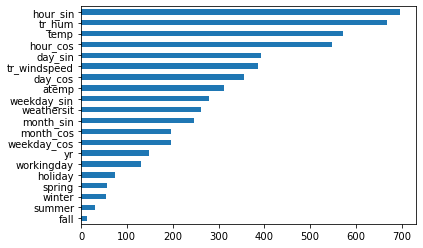

In [244]:
features_imp.plot.barh()

- As seen from the feature weights from the XGBRegressor, `hour`, `hum`, and `temp` are the most important features.  
- We can also conclude from the plot that current `season` is less important than current `hour`
- As to the `temp` vs `atemp` importance, the weight of `temp` is significantly larger therefore we might argue that the actual temperature is more important that the feeling temperature

**Part 2. Regression models by year**

- Year0

In [204]:
X_train_yr0, X_test_yr0, y_train_yr0, y_test_yr0 = train_test_split(
    X_tr_scaled[X_tr_scaled['yr']==0].drop(['tr_casual', 'tr_registered', 'tr_cnt'],axis=1), 
    X_tr_scaled[X_tr_scaled['yr']==0]['tr_cnt'], test_size=0.3)

In [206]:
xgb = XGBRegressor()
xgb.fit(X_train_yr0, y_train_yr0)
y_pred_yr0 = xgb.predict(X_test_yr0)
print(f'R2 score: {r2_score(y_pred_yr0, y_test_yr0)}')

R2 score: 0.9537896010451443


In [207]:
CV(xgb, X_train_yr0, y_train_yr0, kfold)

Mean CV score for 5 folds = 0.9529237033724174


- Year1

In [205]:
X_train_yr1, X_test_yr1, y_train_yr1, y_test_yr1 = train_test_split(
    X_tr_scaled[X_tr_scaled['yr']==1].drop(['tr_casual', 'tr_registered', 'tr_cnt'],axis=1), 
    X_tr_scaled[X_tr_scaled['yr']==1]['tr_cnt'], test_size=0.3)

In [208]:
xgb.fit(X_train_yr1, y_train_yr1)
y_pred_yr1 = xgb.predict(X_test_yr1)
print(f'R2 score: {r2_score(y_pred_yr1, y_test_yr1)}')

R2 score: 0.9633595436283643


In [209]:
CV(xgb, X_train_yr1, y_train_yr1, kfold)

Mean CV score for 5 folds = 0.962920940540503


- Predicting Year1 `cnt` values based on Year0 predictors. 

In [210]:
xgb.fit(X_train_yr0, y_train_yr0)
y_pred_yr1 = xgb.predict(X_test_yr1)
print(f'R2 score: {r2_score(y_pred_yr1, y_test_yr1)}')

R2 score: 0.7079332698024021


The R2 metric dropped by -~20% due to the overfitting taking place in the original model. Since no regularization was introduced, the decision tree most likely overfitted the training dataset and could not produce the same level of prediction for the test data.

**Part 3. MULTITARGET MODEL**

In [211]:
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(
    X_tr_scaled.drop(['tr_casual', 'tr_registered', 'tr_cnt'],axis=1), 
    X_tr_scaled[['tr_casual', 'tr_registered', 'tr_cnt']], test_size=0.3)

- Target = `casual`

In [212]:
xgb.fit(X_train_mult,y_train_mult['tr_casual'])
y_pred_mult_casual = xgb.predict(X_test_mult)
print(f'R2 score: {r2_score(y_pred_mult_casual, y_test_mult.tr_casual)}')

R2 score: 0.9009325863901902


In [213]:
CV(xgb, X_train_mult, y_train_mult.tr_casual, kfold)

Mean CV score for 5 folds = 0.9048614187459088


- Target = `registered`

In [214]:
xgb.fit(X_train_mult,y_train_mult['tr_registered'])
y_pred_mult_registered = xgb.predict(X_test_mult)
print(f'R2 score: {r2_score(y_pred_mult_registered, y_test_mult.tr_registered)}')

R2 score: 0.9640746828816207


In [215]:
CV(xgb, X_train_mult, y_train_mult.tr_registered, kfold)

Mean CV score for 5 folds = 0.9606671581343909


- Target = `cnt`. Sum of the `registered_pred` and `casual_pred` as predictors

In [216]:
X_sum = y_pred_mult_casual + y_pred_mult_registered

In [217]:
X_sum_df = pd.DataFrame(X_sum)

In [218]:
X_sum_train, X_sum_test, y_train_cnt, y_test_cnt = train_test_split(X_sum_df, y_test_mult.tr_cnt, test_size=0.2)

In [219]:
xgb.fit(X_sum_train, y_train_cnt)
y_pred_cnt = xgb.predict(X_sum_test)
print(f'R2 score: {r2_score(y_pred_cnt, y_test_cnt)}')

R2 score: 0.9141331150284202


The R2 score is a bit lower than in the one-target models by year. This might be due to the information loss that occured when only including the `registered_pred` and `casual_pred` and not the other important features directly. Since the XGBRegressor  for `registered_pred` and `casual_pred` learned only a part of the features' variance, some part of it has not been included into the final model for `cnt` automatically.  